# French Bonds Analysis
This notebook scrapes French funds data from tradingeconomics.com , performs analysis, and creates visualizations.

In [1]:
import numpy as np
import requests
import csv
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('deep')


# Web Scraping

In [2]:
def scrape_french_bonds():
    url = 'https://tradingeconomics.com/france/20-year-bond-yield'
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'}
    
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Initialize lists to store data
        maturities = []
        yields = []
        
        # Find the table containing bond data
        table = soup.find('table')
        if table:
            rows = table.find_all('tr')[1:]  # Skip header row
            for row in rows:
                cols = row.find_all('td')
                if len(cols) >= 2:
                    maturities.append(cols[0].text.strip())
                    yields.append(float(cols[1].text.strip().replace('%', '')))
        
        # Create DataFrame
        df = pd.DataFrame({
            'Maturity': maturities,
            'Yield': yields
        })
        
        return df
    
    except Exception as e:
        print(f'Error scraping data: {e}')
        return None

# Fecth The Data

In [3]:
bonds_df = scrape_french_bonds()

if bonds_df is not None:
    print('French Government Bonds Data:')
    display(bonds_df)

French Government Bonds Data:


,Maturity,Yield
0,France 10Y,3.22
1,France 1M,2.46
2,France 52W,2.26
3,France 20Y,3.54
4,France 2Y,2.23
5,France 30Y,3.77
6,France 3M,2.42
7,France 3Y,2.34
8,France 5Y,2.65
9,France 6M,2.36


# Yield Curve

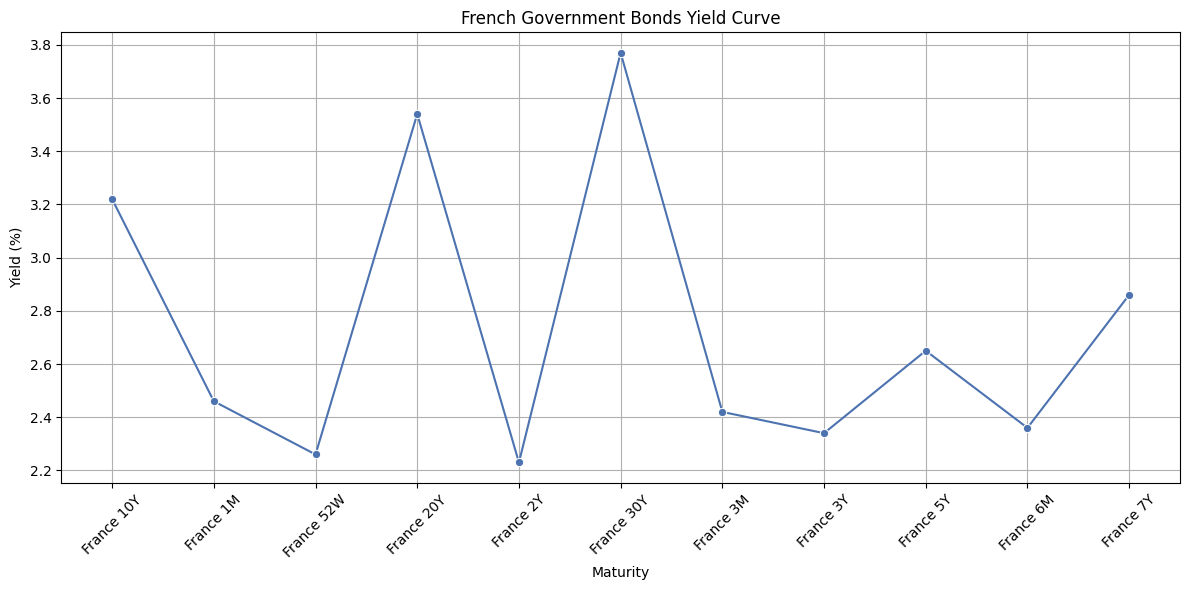

In [4]:
if bonds_df is not None:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=bonds_df, x='Maturity', y='Yield', marker='o')
    plt.title('French Government Bonds Yield Curve')
    plt.xlabel('Maturity')
    plt.ylabel('Yield (%)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

The Statistical Information:
Variance, Expected Value, Standard Deviation



In [5]:
if bonds_df is not None:
    
    average_yield = bonds_df['Yield'].mean()
    variance_yield = bonds_df['Yield'].var()
    std_deviation_yield = bonds_df['Yield'].std()

    print("\nStatistics for Current Yield Curve Data:")
    print(f"Average Yield: {average_yield:.2f}")
    print(f"Variance of Yield: {variance_yield:.2f}")
    print(f"Standard Deviation of Yield: {std_deviation_yield:.2f}")
else:
    print("bonds_df is None.  Cannot calculate statistics.")


Statistics for Current Yield Curve Data:
Average Yield: 2.74
Variance of Yield: 0.29
Standard Deviation of Yield: 0.54


# Analysis of volatiles

c:\Users\egeuz\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


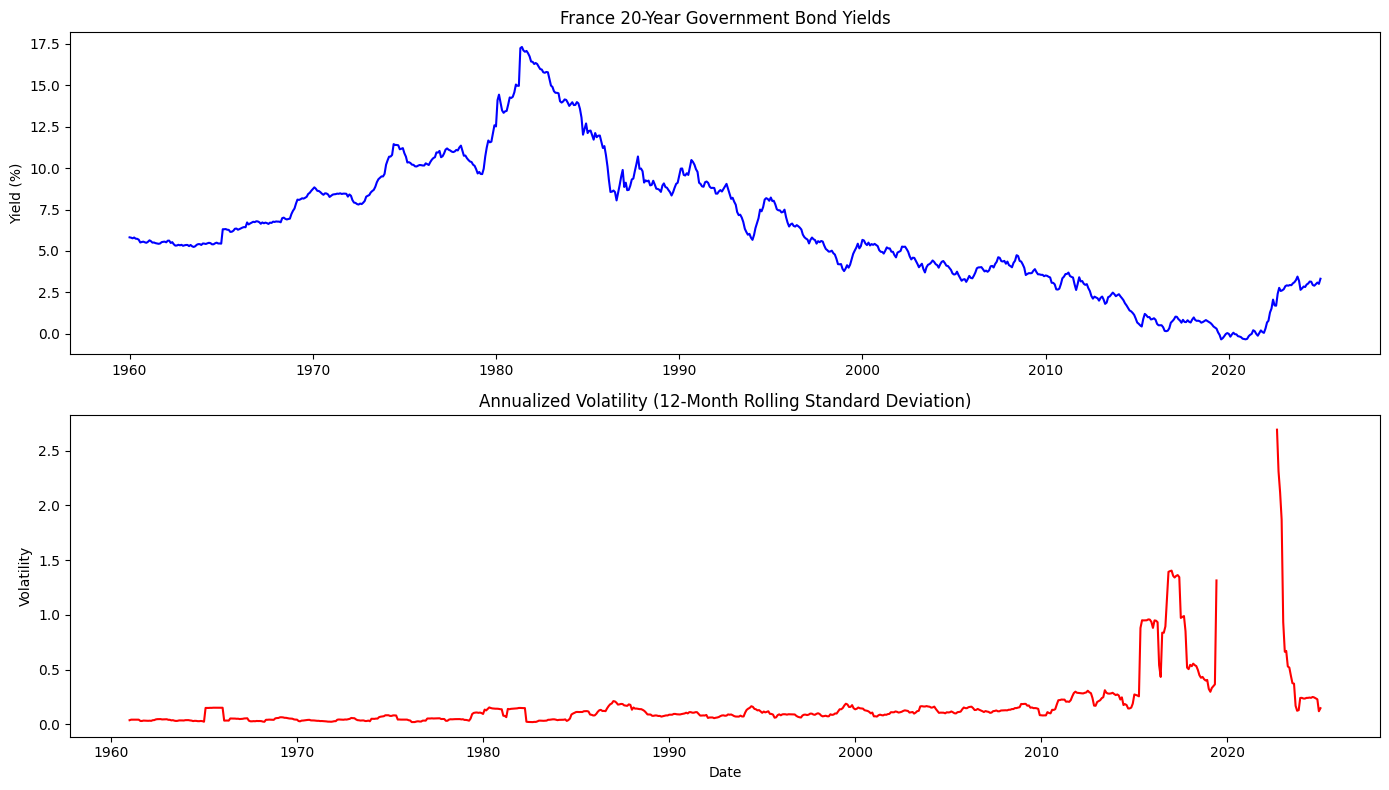

In [9]:
df = pd.read_csv('IRLTLT01FRM156N.csv', parse_dates=['observation_date'])
df.set_index('observation_date', inplace=True)


df.dropna(inplace=True)
df['log_return'] = np.log(df['IRLTLT01FRM156N'] / df['IRLTLT01FRM156N'].shift(1))

# Calculate annualized volatility (12-month rolling window, scaled by √12 for annualization)
window_size = 12
df['volatility'] = df['log_return'].rolling(window=window_size).std() * np.sqrt(12)

# Visualization
plt.figure(figsize=(14, 8))

# Plot bond yields
plt.subplot(2, 1, 1)
plt.plot(df.index, df['IRLTLT01FRM156N'], color='blue')
plt.title('France 20-Year Government Bond Yields')
plt.ylabel('Yield (%)')

# Plot volatility
plt.subplot(2, 1, 2)
plt.plot(df.index, df['volatility'], color='red')
plt.title('Annualized Volatility (12-Month Rolling Standard Deviation)')
plt.xlabel('Date')
plt.ylabel('Volatility')

plt.tight_layout()
plt.show()